In [1]:
# importing required packages

# import re, collections
# from collections import defaultdict
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load('en') #load english language model
from spacy import displacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

np.random.seed(42)
%matplotlib inline

In [2]:
myDir = Path.cwd().parents[0]
dataFolder = myDir / 'data/asap-sas'
ratingsFolder = myDir / 'data/ratings'
figureFolder = myDir / 'figures'


#print(dataFolder)
#print(figureFolder)


### Functions for mapping and getting some clean text

In [3]:
gradeMap = {1: 10,
                2: 10,
                3: 10,
                4:10,
                5: 10,
                6: 10,
                7:10,
                8:10,
                9:10,
                10:8}

subjectMap = {1: 'Science',
            2: 'Science',
            3: 'English Language Arts',
            4: 'English Language Arts',
            5: 'Biology',
            6: 'Biology',
            7:'English',
            8:'English',
            9:'English',
            10:'Science'}

scoreMap = {0: 0,
            1: 1,
            2: 2,
            3: 2}

In [56]:
def get_feature_stats(col):
    
    #features_df = pd.DataFrame(index=col.index)
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    total_words = []
    words_no_punct = []
    words_no_punct_no_stop =[]
    count_content_words=[]
    count_stopwords=[]
    avg_word_len = []
    
    
    aoa_ratings_df = pd.read_csv(ratingsFolder/'AoA_Ratings.csv')
    aoa_ratings = dict(zip(aoa_ratings_df.Word, aoa_ratings_df.AoA))
    maturity_tokens = []
    maturity = []

    conc_ratings_df = pd.read_csv(ratingsFolder/'Concreteness_Ratings.csv')
    conc_ratings = dict(zip(conc_ratings_df.Word, conc_ratings_df.Concreteness))
    concreteness = []
    conc_tokens = []    


    for doc in nlp.pipe(col, batch_size=1000, n_threads=4):

        if doc.is_parsed:
            
            #Add placeholders for CONTENT words, else parse as usual
            #tokens.append(['__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc])
            
            total_words.append(len([w.text for w in doc]))
            words_no_punct.append(len([w.text for w in doc if not w.is_punct]))
            words_no_punct_no_stop.append(len([w.text for w in doc if not w.is_punct if not w.is_stop]))
            count_content_words.append(len([w.text for w in doc if w.pos_ in content_words]))
            count_stopwords.append(len([w.text for w in doc if w.is_stop]))
            avg_word_len.append(sum([len(w) for w in doc if not w.is_punct])/len([w for w in doc if not w.is_punct]))
            
            #-------------------Maturity
            mat_tmp = []
            maturity_tokens.append([w.text.lower().strip() if w.lemma_ == '-PRON-' else w.lemma_.lower().strip() for w in doc])

            #maturity.append([value.get('name') for value in d.values()])
            mat_tmp.append([aoa_ratings[t] for a in maturity_tokens for t in a if t in aoa_ratings])

             #Now get avg maturity per doc
            for j in mat_tmp:
                maturity.append(sum(j)/len(j))

            #----------Concreteness
            conc_tmp = []
            conc_tokens.append([w.text.lower().strip() for w in doc])
            conc_tmp.append([conc_ratings[t] for a in conc_tokens for t in a if t in conc_ratings])

            #Now get avg concreteness per doc
            for k in conc_tmp:
                concreteness.append(sum(k)/len(k))

        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails

            #tokens.append(None)
            total_words.append(None)
            words_no_punct.append(None)
            words_no_punct_no_stop.append(None)
            count_content_words.append(None)
            count_stopwords.append(None)
            avg_word_len.append(None)
            maturity.append(None)
            concreteness.append(None)
    
    
    df['total_words'] = total_words
    df['words_no_punct'] = words_no_punct
    df['words_no_punct_no_stop'] = words_no_punct_no_stop
    df['count_content_words'] = count_content_words
    df['count_stopwords'] = count_stopwords
    df['avg_word_len'] = avg_word_len
    df['maturity'] = maturity
    df['concreteness'] = concreteness
    
    
    return df

## Read Data

In [60]:
df = pd.read_csv(dataFolder/'train.tsv', sep='\t', header=0)  #read data into dataframe
df.drop('Score2', inplace=True, axis=1) #Score 2 is for inter-rate reliability only
df.drop('Id', inplace=True, axis=1) #Id was used in Kaggle

#df.head(2)

## Get Text Statistics/Features for analysis

In [64]:
#Map new values
df['subject'] = df['EssaySet'].map(subjectMap)
df['studentGrade'] = df['EssaySet'].map(gradeMap)
df['styleScore'] = df['Score1'].map(scoreMap)

#Get handcrafted features
df['totalChars'] = df['EssayText'].apply(len)
df = get_feature_stats(df['EssayText'])

#Get some clean text
content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
content_only_text = []
function_based_text =[]
function_only_text =[]
pos_tags = []

for doc in nlp.pipe(df['EssayText'], batch_size=1000, n_threads=4, disable=['ner','textcat']):
    if doc.is_parsed:
        content_only_text.append(' '.join(w.string for w in doc if w.pos_ in content_words))
        function_based_text.append(' '.join('__{}__'.format(w.pos_) if w.pos_ in content_words else w.string if w.pos_ == 'PRON' else w.lemma_ for w in doc))
        function_only_text.append(' '.join(w.string for w in doc if w.pos_ not in content_words))
        pos_tags.append(' '.join(w.pos_ for w in doc))      
    else:
        content_only_text.append(None)
        function_based_text.append(None)
        function_only_text.append(None)
        pos_tags.append(None)
        
df['content_only_text'] = content_only_text
df['function_based_text'] = function_based_text
df['function_only_text'] = function_only_text
df['pos_tags'] = pos_tags

df = df[['EssaySet','subject','studentGrade','EssayText','Score1','styleScore','totalChars','total_words','words_no_punct',
'words_no_punct_no_stop','count_content_words','count_stopwords','avg_word_len','maturity','concreteness',
'content_only_text','function_based_text','function_only_text','pos_tages']] #rearrange columns

df.head(2)

In [5]:
df.isna().sum() #no missing values

EssaySet                    0
subject                     0
studentGrade                0
EssayText                   0
Score1                      0
styleScore                  0
totalChars                  0
total_words                 0
words_no_punct              0
words_no_punct_no_stop      0
count_content_words         0
count_stopwords             0
avg_word_len                0
maturity                    0
concreteness                0
content_only_text          28
function_based_text         0
function_only_text        309
pos_tags                    0
dtype: int64

In [264]:
df.describe()

,EssaySet,studentGrade,Score1,styleScore,totalChars,total_words,words_no_punct,words_no_punct_no_stop,count_content_words,count_stopwords,avg_word_len,maturity,concreteness
count,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000,17207.000000
mean,5.589411,9.809380,0.928982,0.885919,236.394084,47.545824,43.027082,21.634161,26.978962,21.392921,4.724084,5.366222,2.436059
std,2.816919,0.587302,0.893335,0.812944,150.548251,30.573454,27.753288,14.035884,17.328087,14.679802,2.174373,0.074913,0.039449
min,1.000000,8.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.228010,2.327707
25%,3.000000,10.000000,0.000000,0.000000,128.000000,26.000000,23.000000,12.000000,15.000000,11.000000,4.097155,5.297230,2.431361
50%,6.000000,10.000000,1.000000,1.000000,218.000000,44.000000,40.000000,20.000000,25.000000,20.000000,4.428571,5.333505,2.450040
75%,8.000000,10.000000,2.000000,2.000000,318.000000,63.000000,57.000000,29.000000,36.000000,29.000000,4.807956,5.432167,2.461743
max,10.000000,10.000000,3.000000,2.000000,1819.000000,389.000000,353.000000,179.000000,221.000000,174.000000,56.500000,5.522903,2.556803


#### Save training and test as seperate files

In [64]:
df = pd.read_csv(dataFolder/'cleaned_full_data.csv', header=0, index_col=0) 
train, test = train_test_split(df, test_size=0.2)

print(len(train), len(test))

train.to_csv(dataFolder/'training.csv',header=True, index=False)  #save data into dataframe
test.to_csv(dataFolder/'test.csv',header=True, index=False)  #save data into dataframe


13765 3442


# Load Training data for Exploration

In [3]:
df = pd.read_csv(dataFolder/'training.csv', header=0)  #read data into dataframe
df.head(2)

,EssaySet,subject,studentGrade,EssayText,Score1,styleScore,totalChars,total_words,words_no_punct,words_no_punct_no_stop,count_content_words,count_stopwords,avg_word_len,maturity,concreteness,content_only_text,function_based_text,function_only_text,pos_tags
0,7,English,10,One trait that describes rose is hard-working....,1,1,120,27,23,12,15,11,4.173913,5.487419,2.449177,trait that describes rose is hard working...,one __NOUN__ __ADJ__ __VERB__ __VERB__ __VERB_...,"One - . I this because she to , but sh...",NUM NOUN ADJ VERB VERB VERB ADV PUNCT VERB PUN...
1,9,English,10,First the author has an introduction to grab t...,1,1,190,38,33,18,20,15,4.666667,5.333607,2.461765,First author has introduction grab reader...,__ADV__ the __NOUN__ __VERB__ an __NOUN__ to _...,"the an to the 's . , the if in the ...",ADV DET NOUN VERB DET NOUN PART VERB DET NOUN ...


In [70]:
# group_count = df.groupby([df.EssaySet,df.subject]).size().reset_index(name='essay_count')
# group_count['EssaySet'] = group_count['EssaySet'].astype(str)
# group_count

In [ ]:
# from matplotlib import style
# #style.available
# style.use('fivethirtyeight')


# Exploratory Analysis

#### 1) Number of responses (Sample size)

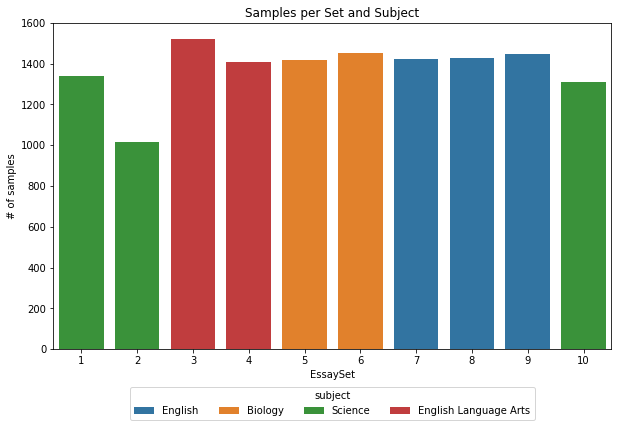

In [5]:
plt.figure(figsize=(10,6))
#plt.subplots(figsize=(10, 6))

g = sns.countplot(x="EssaySet", hue='subject' ,data=df, dodge=False)

g.set_title("Samples per Set and Subject")
g.set_ylabel("# of samples")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=False, ncol=4).set_title("subject")

plt.savefig(figureFolder/"Samples_per_set.svg", format="svg", bbox_inches='tight')

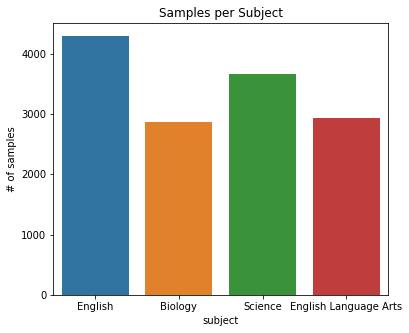

In [6]:
plt.figure(figsize=(6,5))

g = sns.countplot(x="subject", hue='subject' ,data=df, dodge=False)

g.set_title("Samples per Subject")
g.set_ylabel("# of samples")
g.get_legend().set_visible(False)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=False, ncol=4)

plt.savefig(figureFolder/"Samples_per_subject.svg", format="svg", bbox_inches='tight')

#### 2) Distribution of marks across the sets

_*Type of Response*_

1: Source Dependent
2: Source Dependent
3: Source Dependent
4: Source Dependent
5: Non Source
6: Non Source
7: Source Dependent
8: Source Dependent
9: Source Dependent
10: Source Dependent


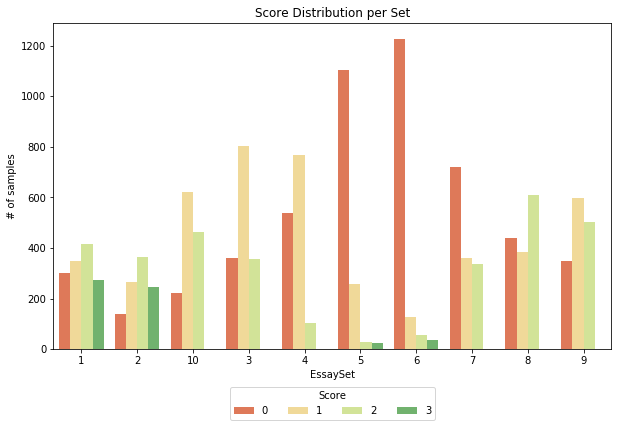

In [7]:
plt.figure(figsize=(10,6))
g = sns.countplot(x="EssaySet", hue="Score1",  data=df, palette='RdYlGn', order=[1,2,10,3,4,5,6,7,8,9])
g.set_title("Score Distribution per Set")
g.set_ylabel("# of samples")

#g.get_legend().set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=False, ncol=4).set_title("Score")

plt.savefig(figureFolder/"ScoreDist_per_set.svg", format="svg", bbox_inches='tight')
#plt.plot([2, 2], [0, 5], linewidth=2)

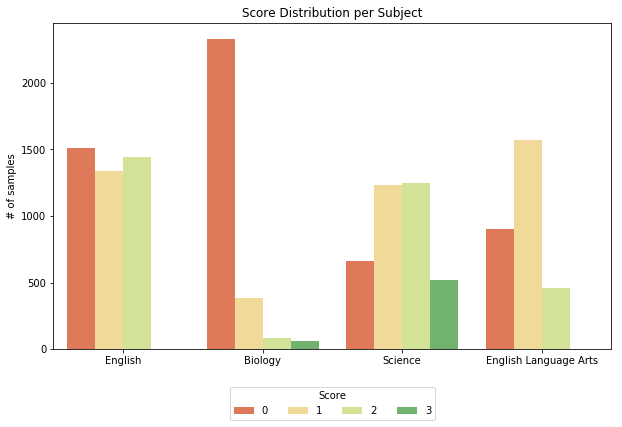

In [8]:
plt.figure(figsize=(10,6))
g = sns.countplot(x="subject", hue="Score1",  data=df, palette='RdYlGn')
g.set_title("Score Distribution per Subject")
g.set_ylabel("# of samples")
g.set_xlabel("")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4).set_title("Score")

plt.savefig(figureFolder/"ScoreDist_per_subject.svg", format="svg", bbox_inches='tight')

#### 3) Response length (total chars)

In [9]:
df.groupby(['subject', 'EssaySet'])['totalChars'].mean()

subject                EssaySet
Biology                5           142.367678
                       6           140.973159
English                7           214.366643
                       8           284.944017
                       9           284.943983
English Language Arts  3           284.919238
                       4           239.754610
Science                1           257.424197
                       2           324.161259
                       10          212.433588
Name: totalChars, dtype: float64

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


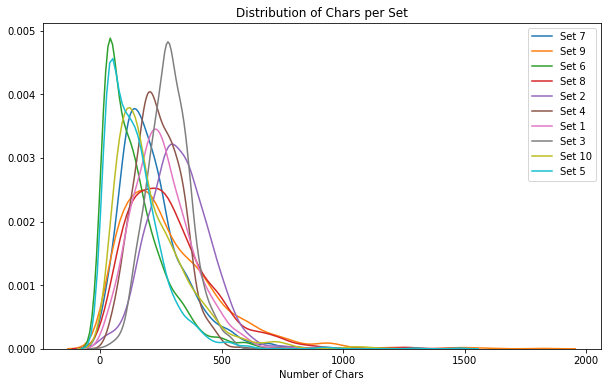

In [10]:
plt.figure(figsize=(10,6))
for i in df.EssaySet.unique():
    
    mydf = df.loc[df.EssaySet == i, 'totalChars']
    sns.distplot(mydf.values,hist=False, label='Set {}'.format(i)).set_title("Distribution of Chars per Set")
    plt.xlabel('Number of Chars')
    
#plt.show()
plt.savefig(figureFolder/"CharsDist_per_set.svg", format="svg", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


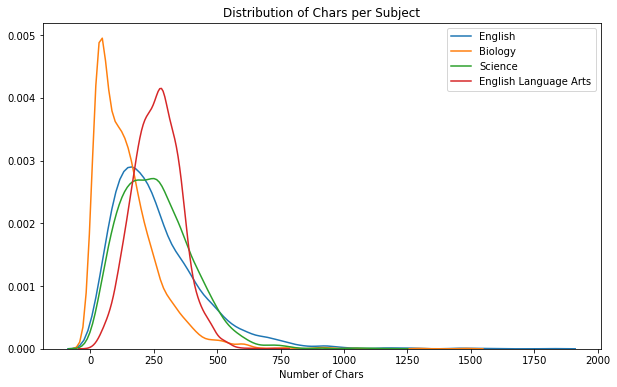

In [11]:
plt.figure(figsize=(10,6))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['totalChars'],hist=False, label= i).set_title("Distribution of Chars per Subject")
    plt.xlabel('Number of Chars')
    
#plt.show()
plt.savefig(figureFolder/"CharsDist_per_Subject.svg", format="svg", bbox_inches='tight')


#### 4) Total Words per Response

total_words

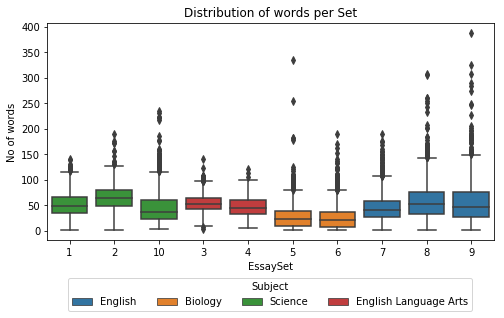

In [12]:
plt.figure(figsize=(8,4))
g = sns.boxplot(x="EssaySet", y="total_words", hue="subject", data=df, order=[1,2,10,3,4,5,6,7,8,9], dodge=False)
g.set_title("Distribution of words per Set")
g.set_ylabel("No of words")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4).set_title("Subject")

plt.savefig(figureFolder/"wordsDist_per_Set.svg", format="svg", bbox_inches='tight')

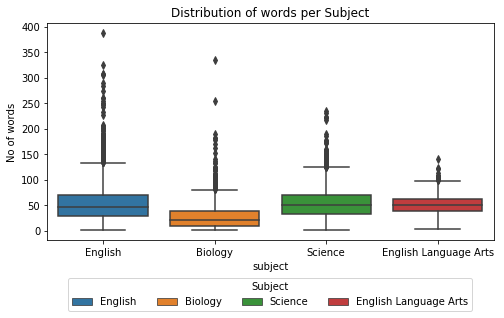

In [13]:
plt.figure(figsize=(8,4))
g = sns.boxplot(x="subject", y="total_words", hue="subject", data=df, dodge=False)
g.set_title("Distribution of words per Subject")
g.set_ylabel("No of words")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4).set_title("Subject")

plt.savefig(figureFolder/"wordsDist_per_Subject.svg", format="svg", bbox_inches='tight')

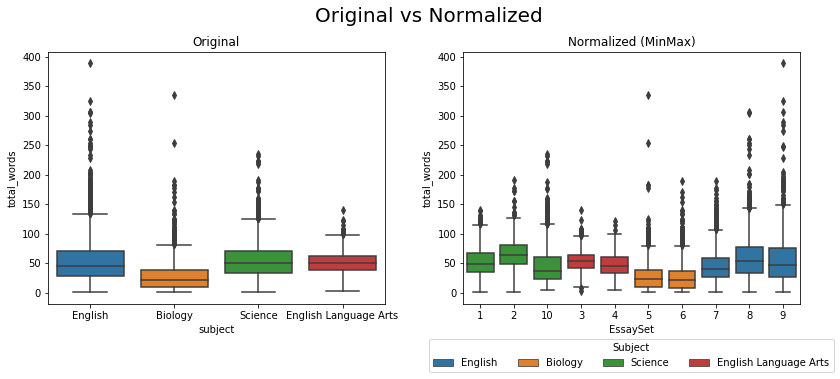

In [14]:
f, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,5))
ax1, ax2 = axes.flatten()

g1 = sns.boxplot(x="EssaySet", y="total_words", hue="subject", data=df, order=[1,2,10,3,4,5,6,7,8,9], dodge=False, ax=ax2)
g1.get_legend().set_visible(False)
g2 = sns.boxplot(x="subject", y="total_words", hue="subject", data=df, dodge=False, ax=ax1)
g2.get_legend().set_visible(False)

#Customise
plt.suptitle("Original vs Normalized", y = 1.05, fontsize=20)
ax1.set_title("Original",  y = 1)
ax2.set_title("Normalized (MinMax)", y = 1)

#fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
axes.flatten()[-1].legend(loc='upper center',bbox_to_anchor=(0.5, -0.12), ncol=4, title="Subject")


plt.tight_layout()

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


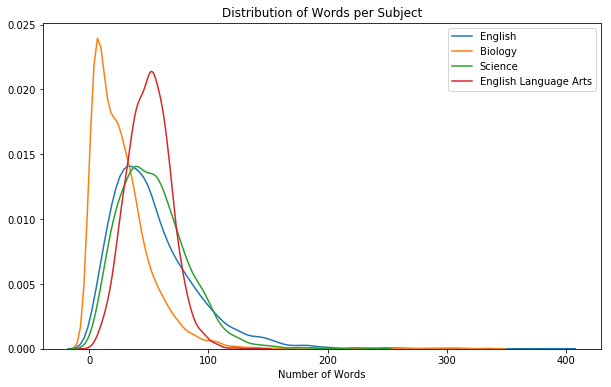

In [15]:
plt.figure(figsize=(10,6))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['total_words'],hist=False, label= i).set_title("Distribution of Words per Subject")
    plt.xlabel('Number of Words')
    
#plt.show()
#plt.savefig(figureFolder/"CharsDist_per_Subject.svg", format="svg", bbox_inches='tight')


#### 4) Avg words per response (exc punctuation)

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


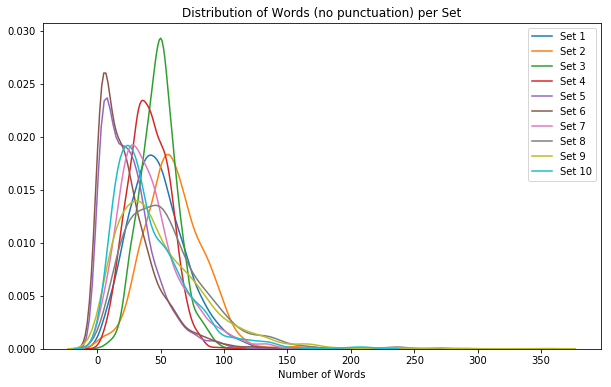

In [16]:
plt.figure(figsize=(10,6))
for i in sorted(df.EssaySet.unique()):
    
    mydf = df.loc[df.EssaySet == i, 'words_no_punct']
    sns.distplot(mydf.values,hist=False, label='Set {}'.format(i)).set_title("Distribution of Words (no punctuation) per Set")
    plt.xlabel('Number of Words')
    
plt.savefig(figureFolder/"nopunct_Dist_per_Set.svg", format="svg", bbox_inches='tight')


C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


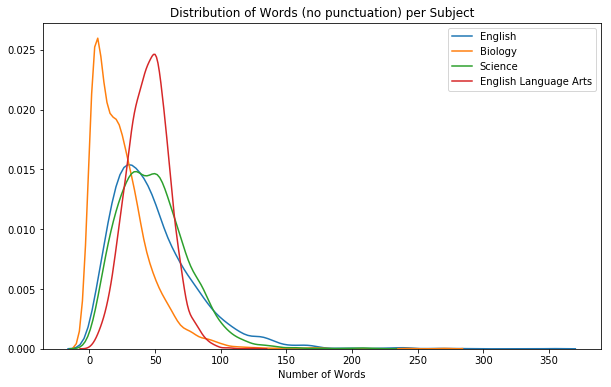

In [17]:
plt.figure(figsize=(10,6))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['words_no_punct'],hist=False, label= i).set_title("Distribution of Words (no punctuation) per Subject")
    plt.xlabel('Number of Words')
    
plt.savefig(figureFolder/"nopunct_Dist_per_Subject.svg", format="svg", bbox_inches='tight')


#### 5) Avg words (without punct, without stopwords)

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


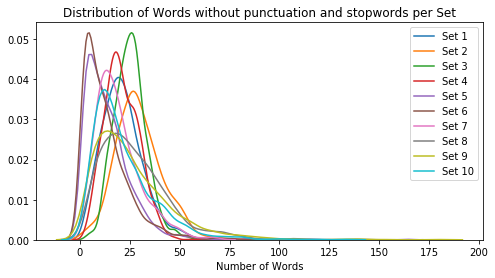

In [18]:
plt.figure(figsize=(8,4))
for i in sorted(df.EssaySet.unique()):
    
    mydf = df.loc[df.EssaySet == i, 'words_no_punct_no_stop']
    sns.distplot(mydf.values,hist=False, label='Set {}'.format(i)).set_title("Distribution of Words without punctuation and stopwords per Set")
    plt.xlabel('Number of Words')
    
#plt.show()
plt.savefig(figureFolder/"words_no_punct_no_stop_per_set.svg", format="svg", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


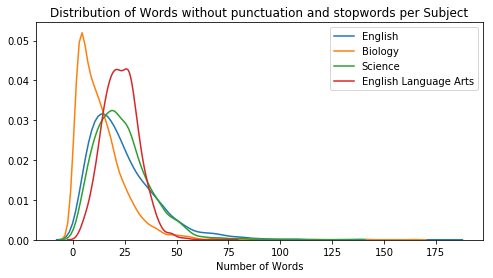

In [19]:
plt.figure(figsize=(8,4))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['words_no_punct_no_stop'],hist=False, label= i).set_title("Distribution of Words without punctuation and stopwords per Subject")
    plt.xlabel('Number of Words')
    
plt.savefig(figureFolder/"words_no_punct_no_stop_per_Subject.svg", format="svg", bbox_inches='tight')


#### 6) Content words 
count_content_words


C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


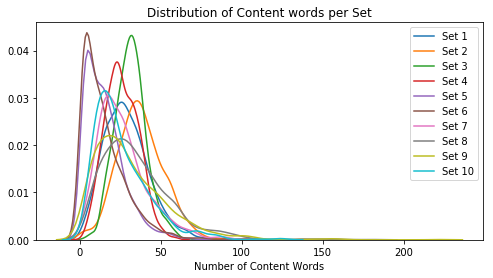

In [20]:
plt.figure(figsize=(8,4))
for i in sorted(df.EssaySet.unique()):
    
    mydf = df.loc[df.EssaySet == i, 'count_content_words']
    sns.distplot(mydf.values,hist=False, label='Set {}'.format(i)).set_title("Distribution of Content words per Set")
    plt.xlabel('Number of Content Words')
    
#plt.show()
plt.savefig(figureFolder/"content_words_per_set.svg", format="svg", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


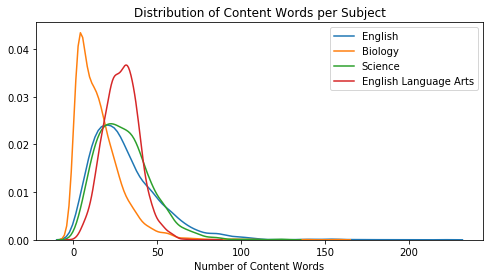

In [21]:
plt.figure(figsize=(8,4))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['count_content_words'],hist=False, label= i).set_title("Distribution of Content Words per Subject")
    plt.xlabel('Number of Content Words')
    
plt.savefig(figureFolder/"content_words_per_Subject.svg", format="svg", bbox_inches='tight')


#### 7) Stopwords
count_stopwords

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


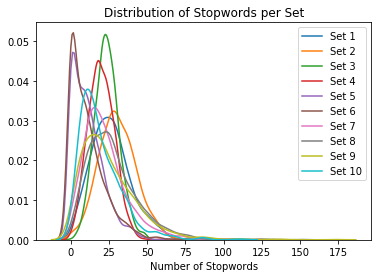

In [22]:
plt.figure(figsize=(6,4))
for i in sorted(df.EssaySet.unique()):
    
    mydf = df.loc[df.EssaySet == i, 'count_stopwords']
    sns.distplot(mydf.values,hist=False, label='Set {}'.format(i)).set_title("Distribution of Stopwords per Set")
    plt.xlabel('Number of Stopwords')
    
#plt.show()
plt.savefig(figureFolder/"stopwords_per_set.svg", format="svg", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


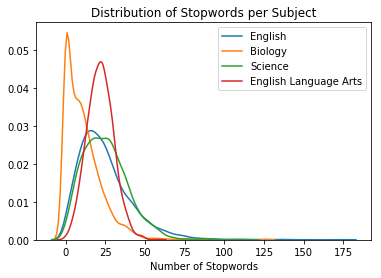

In [23]:
plt.figure(figsize=(6,4))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['count_stopwords'],hist=False, label= i).set_title("Distribution of Stopwords per Subject")
    plt.xlabel('Number of Stopwords')
    
plt.savefig(figureFolder/"stopwords_per_Subject.svg", format="svg", bbox_inches='tight')


#### 8) Avg word length

avg_word_len

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


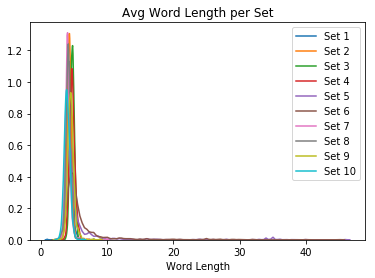

In [24]:
plt.figure(figsize=(6,4))
for i in sorted(df.EssaySet.unique()):
    
    mydf = df.loc[df.EssaySet == i, 'avg_word_len']
    sns.distplot(mydf.values,hist=False, label='Set {}'.format(i)).set_title("Avg Word Length per Set")
    plt.xlabel('Word Length')
    
#plt.show()
plt.savefig(figureFolder/"avg_word_length_per_set.svg", format="svg", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


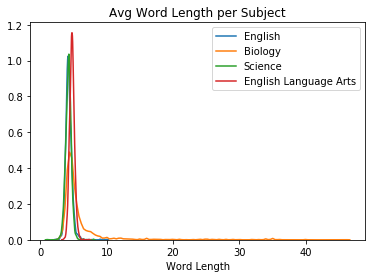

In [25]:
plt.figure(figsize=(6,4))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['avg_word_len'],hist=False, label= i).set_title("Avg Word Length per Subject")
    plt.xlabel('Word Length')
    
plt.savefig(figureFolder/"avg_word_length_per_Subject.svg", format="svg", bbox_inches='tight')


#### 9) Maturity

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


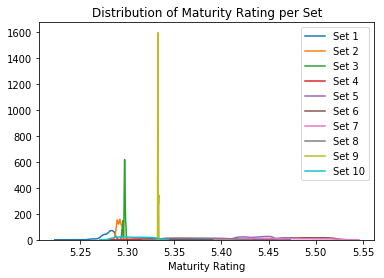

In [26]:
plt.figure(figsize=(6,4))
for i in sorted(df.EssaySet.unique()):
    
    mydf = df.loc[df.EssaySet == i, 'maturity']
    sns.distplot(mydf.values,hist=False, label='Set {}'.format(i)).set_title("Distribution of Maturity Rating per Set")
    plt.xlabel('Maturity Rating')
    
#plt.show()
plt.savefig(figureFolder/"maturity_per_set.svg", format="svg", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


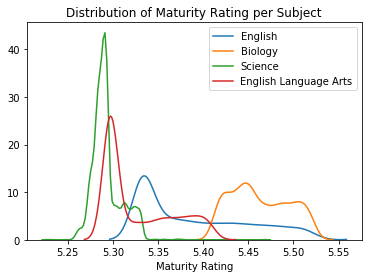

In [27]:
plt.figure(figsize=(6,4))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['maturity'],hist=False, label= i).set_title("Distribution of Maturity Rating per Subject")
    plt.xlabel('Maturity Rating')
    
plt.savefig(figureFolder/"maturity_per_Subject.svg", format="svg", bbox_inches='tight')


#### 10) Concreteness

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


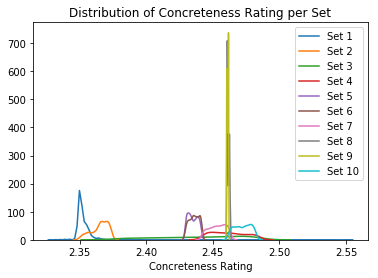

In [28]:
plt.figure(figsize=(6,4))
for i in sorted(df.EssaySet.unique()):
    
    mydf = df.loc[df.EssaySet == i, 'concreteness']
    sns.distplot(mydf.values,hist=False, label='Set {}'.format(i)).set_title("Distribution of Concreteness Rating per Set")
    plt.xlabel('Concreteness Rating')
    
#plt.show()
plt.savefig(figureFolder/"concreteness_per_set.svg", format="svg", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


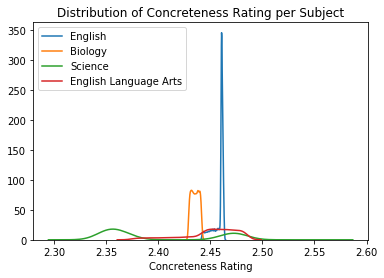

In [29]:
plt.figure(figsize=(6,4))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['concreteness'],hist=False, label= i).set_title("Distribution of Concreteness Rating per Subject")
    plt.xlabel('Concreteness Rating')
    
plt.savefig(figureFolder/"concreteness_per_Subject.svg", format="svg", bbox_inches='tight')


## Vocabulary & Token Frequency

In [30]:
from yellowbrick.text import FreqDistVisualizer

### Content Based

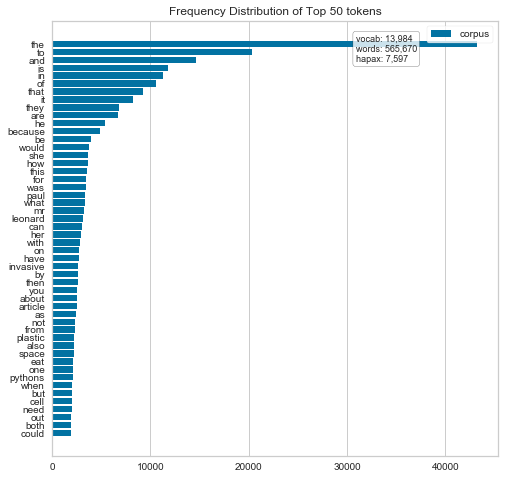

In [55]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['EssayText'])
features   = vectorizer.get_feature_names()

plt.figure(figsize=(8,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.set_title("Top 50 tokens overall")
visualizer.poof()

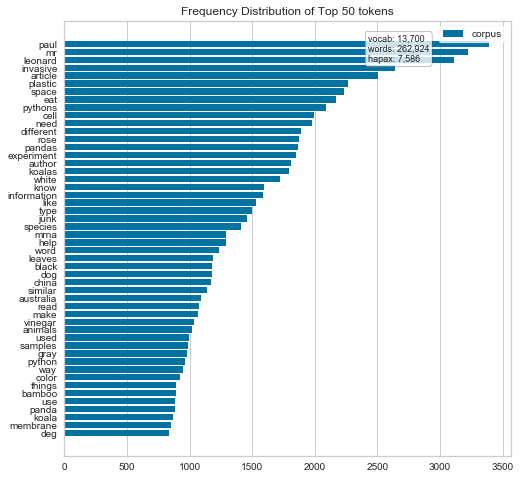

In [54]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(df['EssayText'])
features   = vectorizer.get_feature_names()

plt.figure(figsize=(8,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.set_title("Top 50 tokens Overall after stopwords removal")
visualizer.poof()

### Function Based Words

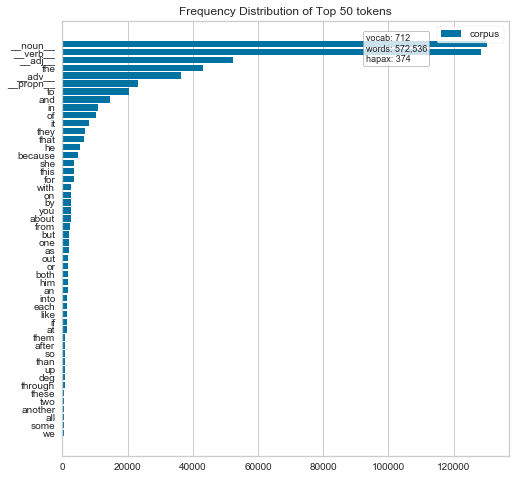

In [57]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['function_based_text'])
features   = vectorizer.get_feature_names()

plt.figure(figsize=(8,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.set_title("Top 50 tokens over Function Based Text")
visualizer.poof()

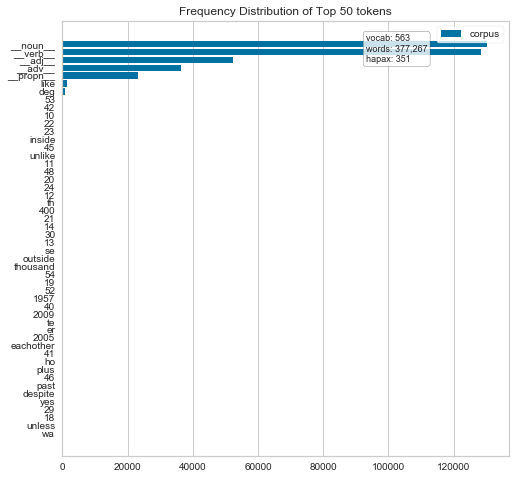

In [58]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(df['function_based_text'])
features   = vectorizer.get_feature_names()

plt.figure(figsize=(8,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.set_title("Top 50 tokens over Function Based Text")
visualizer.poof()

In [32]:
#len(vectorizer.vocabulary_)

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(10,5), )

sns.countplot(x="Score1", data=df[~(df.subject == "Biology")], orient='v', hue="Score1", ax=ax1)
sns.countplot(x="styleScore", data=df[~(df.subject == "Biology")], orient='v', hue="styleScore", ax=ax2)

#Customise title
plt.suptitle("Original vs Normalized", y = 1.05, fontsize=20)
ax1.set_title("Original",  y = 1)
ax2.set_title("Normalized (MinMax)", y = 1)
plt.tight_layout()

### Visualising with diSpaCy

In [15]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple PROPN nsubj
is VERB aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN compound
startup NOUN dobj
for ADP prep
$ SYM quantmod
1 NUM compound
billion NUM pobj


In [40]:
doc = nlp(tem_df['EssayText'].iloc[4])
doc.user_data['title'] = 'This is a title'
sentence_spans = list(doc.sents)

options = {'compact': True}
#displacy.render(doc, style='dep', jupyter=True)#options={'distance':140}

#Long texts can be visualised sentence by sentence
displacy.render(sentence_spans, style='dep', jupyter=True, options=options)


# colors = {'ORG': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)'}
# options = {'ents': ['ORG'], 'colors': colors}
# displacy.serve(doc, style='ent', options=options)




# svg = displacy.render(doc, style='dep')
# file_name = '-'.join([w.text for w in doc if not w.is_punct]) + '.svg'
# output_path = Path('/images/' + file_name)
# output_path.open('w', encoding='utf-8').write(svg)